In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('../Data/jose_phishing/CEAS_08.csv')
df.head()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39154 non-null  object
 1   receiver  38692 non-null  object
 2   date      39154 non-null  object
 3   subject   39126 non-null  object
 4   body      39154 non-null  object
 5   label     39154 non-null  int64 
 6   urls      39154 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB


sender        0
receiver    462
date          0
subject      28
body          0
label         0
urls          0
dtype: int64

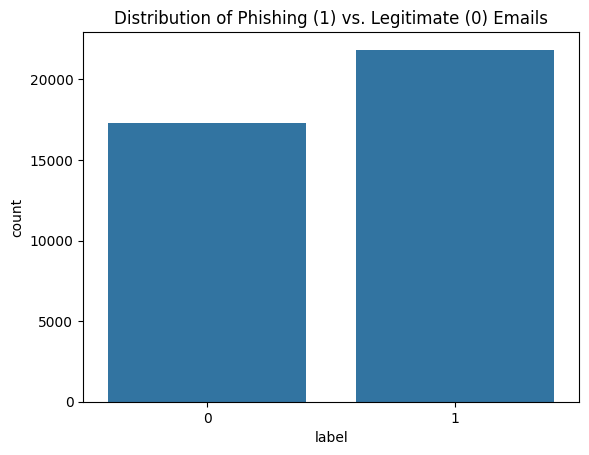

In [3]:
# Distribuție coloanelor
sns.countplot(x='label', data=df)
plt.title('Distribution of Phishing (1) vs. Legitimate (0) Emails')
plt.show()

In [4]:
# Analyzing the date column
df['date'] = pd.to_datetime(df['date'], format='%a, %d %b %Y %H:%M:%S %z', errors='coerce', utc=True)
print(df['date'].dtype)

datetime64[ns, UTC]


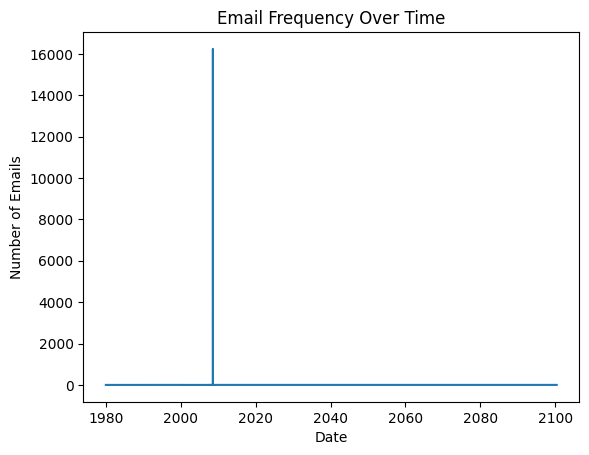

In [5]:
# Creating separate columns for Date and Time
df['Date'] = df['date'].dt.date
df['Time'] = df['date'].dt.time

# Handling any remaining NaT values (if any)
df = df.dropna(subset=['date'])

# Plotting the distribution of emails over time
df['Date'].value_counts().sort_index().plot()
plt.title('Email Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Emails')
plt.show()

Accuracy: 0.6134983384897444
Confusion Matrix:
[[2646 1693]
 [1680 2708]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.61      0.61      4339
         1.0       0.62      0.62      0.62      4388

    accuracy                           0.61      8727
   macro avg       0.61      0.61      0.61      8727
weighted avg       0.61      0.61      0.61      8727



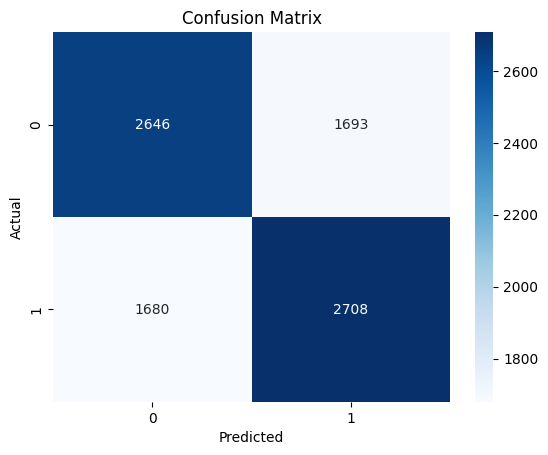

In [6]:
# Preprocessing the body text
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Transform the body text to TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['body'])

# Combining other features with TF-IDF features
features = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
features['urls'] = df['urls']
features['label'] = df['label']

# Ensure there are no missing values in the features
features = features.dropna()

# Splitting the dataset into features and target
X = features.drop('label', axis=1)
y = features['label']

# Handle imbalanced data using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Building a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=1)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

# Visualizing the Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [7]:
import os
import email
from email import policy
from email.parser import BytesParser
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Funcție pentru încărcarea textului dintr-un fișier .eml
def load_eml_file(filepath):
    with open(filepath, 'rb') as f:
        msg = BytesParser(policy=policy.default).parse(f)
    # Încearcă să extragi partea text/plain a mesajului
    text_part = msg.get_body(preferencelist=('plain'))
    if text_part:
        return text_part.get_content()
    else:
        return ""

# Funcție pentru încărcarea dataset-ului (spam și ham)
def load_dataset(folder_spam, folder_ham):
    texts = []
    labels = []
    # Încarcă email-urile spam
    for filename in os.listdir(folder_spam):
        if filename.endswith(".eml"):
            filepath = os.path.join(folder_spam, filename)
            content = load_eml_file(filepath)
            texts.append(content)
            labels.append(1)  # spam etichetat ca 1
    # Încarcă email-urile ham
    for filename in os.listdir(folder_ham):
        if filename.endswith(".eml"):
            filepath = os.path.join(folder_ham, filename)
            content = load_eml_file(filepath)
            texts.append(content)
            labels.append(0)  # ham etichetat ca 0
    return texts, labels

# Specifică directoarele cu fișierele .eml
folder_spam = "data/spam"
folder_ham = "data/ham"

texts, labels = load_dataset(folder_spam, folder_ham)
print("Numărul total de email-uri:", len(texts))

# Împarte datele în set de antrenament și test
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Preprocesarea textului: tokenizare și padding
max_words = 10000  # numărul maxim de cuvinte reținute
max_len = 200      # lungimea maximă a secvențelor

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Construiește modelul neural (LSTM)
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Antrenează modelul
epochs = 5
batch_size = 32

history = model.fit(X_train_pad, np.array(y_train),
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1)

# Evaluează modelul pe setul de test
loss, accuracy = model.evaluate(X_test_pad, np.array(y_test))
print("Acuratețea pe setul de test:", accuracy)

# Funcție pentru clasificarea unui email nou
def classify_email(filepath):
    content = load_eml_file(filepath)
    seq = tokenizer.texts_to_sequences([content])
    pad_seq = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(pad_seq)
    label = "spam" if pred[0][0] >= 0.5 else "ham"
    print("Predicție:", label, "(probabilitate: {:.2f})".format(pred[0][0]))

# Exemplu de utilizare: clasifică un email nou
new_email_path = "data/new_email.eml"
classify_email(new_email_path)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/spam'